Initial Q-table:
State 0: tensor([-0.1961, -0.1085, -0.0865, -0.1836], grad_fn=<ViewBackward0>)
State 1: tensor([-0.1954, -0.1096, -0.0861, -0.1907], grad_fn=<ViewBackward0>)
State 2: tensor([-0.1944, -0.1089, -0.0864, -0.1904], grad_fn=<ViewBackward0>)
State 3: tensor([-0.1944, -0.1071, -0.0818, -0.1885], grad_fn=<ViewBackward0>)
State 4: tensor([-0.2006, -0.1133, -0.0909, -0.1893], grad_fn=<ViewBackward0>)
State 5: tensor([-0.1990, -0.1114, -0.0892, -0.1855], grad_fn=<ViewBackward0>)
State 6: tensor([-0.2031, -0.1138, -0.0934, -0.1813], grad_fn=<ViewBackward0>)
State 7: tensor([-0.1959, -0.1104, -0.0884, -0.1910], grad_fn=<ViewBackward0>)
State 8: tensor([-0.2005, -0.1120, -0.0884, -0.1872], grad_fn=<ViewBackward0>)
State 9: tensor([-0.1990, -0.1124, -0.0902, -0.1902], grad_fn=<ViewBackward0>)
State 10: tensor([-0.1992, -0.1106, -0.0850, -0.1867], grad_fn=<ViewBackward0>)
State 11: tensor([-0.1943, -0.1101, -0.0882, -0.1931], grad_fn=<ViewBackward0>)
State 12: tensor([-0.1965, -0.110

ValueError: x, y, and format string must not be None

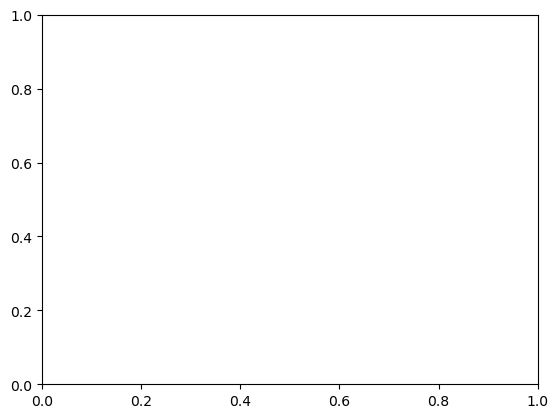

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

class GridWorld:
    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols
        self.start = (rows - 1, 0)  # Bottom left corner
        self.goal = (rows - 1, cols - 1)  # Bottom right corner
        self.cliff = [(rows - 1, j) for j in range(1, cols - 1)]  # Cliff cells
        self.agent_pos = self.start

    def reset(self):
        self.agent_pos = self.start
        return self.agent_pos

    def step(self, action):
        next_row, next_col = self.agent_pos

        if action == 0:  # Up
            next_row -= 1
        elif action == 1:  # Down
            next_row += 1
        elif action == 2:  # Left
            next_col -= 1
        elif action == 3:  # Right
            next_col += 1

        next_row = max(0, min(next_row, self.rows - 1))
        next_col = max(0, min(next_col, self.cols - 1))

        self.agent_pos = (next_row, next_col)

        reward = -5  # Default reward for moving

        if self.agent_pos in self.cliff:
            reward = -500  # Cliff penalty
            self.agent_pos = self.start  # Reset to start if fallen into the cliff

        done = self.agent_pos == self.goal

        return self.agent_pos, reward, done, {}

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 16)
        self.fc4 = nn.Linear(16, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

def epsilon_greedy_action(q_values, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(len(q_values))
    else:
        return np.argmax(q_values)

def q_learning(env, q_network, optimizer, num_episodes, epsilon_decay):
    gamma = 0.7
    epsilon = 0.9
    input_dim = env.rows * env.cols
    output_dim = 4  # Four possible actions: Up, Down, Left, Right

    print("Initial Q-table:")
    print_q_table(q_network, input_dim)

    for episode in range(1, num_episodes + 1):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            state_one_hot = np.zeros(input_dim)
            state_one_hot[state[0] * env.cols + state[1]] = 1

            q_values = q_network(torch.tensor(state_one_hot, dtype=torch.float32))
            action = epsilon_greedy_action(q_values.data.numpy(), epsilon)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            if done:
                q_values_target = reward
            else:
                next_state_one_hot = np.zeros(input_dim)
                next_state_one_hot[next_state[0] * env.cols + next_state[1]] = 1
                next_q_values = q_network(torch.tensor(next_state_one_hot, dtype=torch.float32))
                q_values_target = reward + gamma * torch.max(next_q_values).item()

            q_values[action] = q_values_target

            loss = nn.MSELoss()(q_network(torch.tensor(state_one_hot, dtype=torch.float32)), q_values.unsqueeze(0))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state

        epsilon *= epsilon_decay
        print(f"Episode {episode}, Total Reward: {total_reward}")

    print("Final Q-table:")
    print_q_table(q_network, input_dim)

def print_q_table(q_network, input_dim):
    for state in range(input_dim):
        state_one_hot = np.zeros(input_dim)
        state_one_hot[state] = 1
        q_values = q_network(torch.tensor(state_one_hot, dtype=torch.float32))
        print(f"State {state}: {q_values}")
        
        
def visualize_episode(env, q_network):
    cmap = ListedColormap(['white', 'red', 'green', 'blue'])
    grid = np.zeros((env.rows, env.cols))
    grid[env.start] = 2  # Start position
    grid[env.goal] = 3  # Goal position
    for cliff_pos in env.cliff:
        grid[cliff_pos] = 1  # Cliff positions

    state = env.reset()
    plt.figure(figsize=(6, 6))

    while True:
        plt.imshow(grid, cmap=cmap, origin='upper')
        plt.title("Grid World")
        plt.pause(0.5)
        plt.cla()

        state_one_hot = np.zeros(env.rows * env.cols)
        state_one_hot[state[0] * env.cols + state[1]] = 1
        q_values = q_network(torch.tensor(state_one_hot, dtype=torch.float32)).detach().numpy()
        action = np.argmax(q_values)

        next_state, _, done, _ = env.step(action)
        if done:
            break
        state = next_state

    plt.imshow(grid, cmap=cmap, origin='upper')
    plt.title("Grid World")
    plt.pause(0.5)
    plt.close()

if __name__ == "__main__":
    env = GridWorld(6, 10)

    input_dim = env.rows * env.cols
    output_dim = 4  # Four possible actions: Up, Down, Left, Right

    q_network = QNetwork(input_dim, output_dim)
    optimizer = optim.Adam(q_network.parameters(), lr=0.001)

    episode_rewards=q_learning(env, q_network, optimizer, num_episodes=2, epsilon_decay=0.99)
    
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode')
    plt.show()

    visualize_episode(env, q_network)